In [2]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim

# Getting dataset ready

In [3]:
def get_npy_file_paths(directory):
    return sorted(glob.glob(os.path.join(directory, "*.npy")))

# load file paths 
lr_dir = "/kaggle/input/dataset-3b/Dataset/LR"  
hr_dir = "/kaggle/input/dataset-3b/Dataset/HR"
lr_path =  get_npy_file_paths(lr_dir)
hr_path = get_npy_file_paths(hr_dir)


In [4]:
lr_path_tr,lr_path_test = train_test_split(lr_path,train_size=0.9, shuffle=True,random_state=42)
hr_path_tr,hr_path_test = train_test_split(hr_path,train_size=0.9, shuffle=True,random_state=42)

In [5]:
# custom dataset class
class SRDataset(Dataset):
    def __init__(self, lr_path, hr_path, transform=None):
        self.lr_path = lr_path
        self.hr_path = hr_path
        self.transform = transform

    def __len__(self):
        return len(self.lr_path)

    def __getitem__(self, idx):
        lr = np.load(self.lr_path[idx]).astype(np.float32)  # Low-resolution image
        hr = np.load(self.hr_path[idx]).astype(np.float32)  # High-resolution image

        if self.transform:
            lr = self.transform(torch.tensor(lr, dtype=torch.float32))  
            hr = self.transform(torch.tensor(hr, dtype=torch.float32))
        return lr, hr

# Define transforms for normalization (-1 to 1 range)
transform = transforms.Compose([
    # transforms.Normalize(mean=[lr_mean], std=[lr_std])
])


In [6]:
# Loading  dataset

dataset_train = SRDataset(lr_path_tr, hr_path_tr, transform=transform)
dataset_test = SRDataset(lr_path_test,hr_path_test,transform=transform)
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset_test,batch_size=16,shuffle=True)

In [7]:

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        return x + self.bn2(self.conv2(self.prelu(self.bn1(self.conv1(x)))))

class Generator(nn.Module):
    def __init__(self, num_res_blocks=16):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, stride=1, padding=4)
        self.prelu = nn.PReLU()

        self.res_blocks = nn.Sequential(*[ResidualBlock(64) for _ in range(num_res_blocks)])

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.upsample = nn.Sequential(
        nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
        nn.PixelShuffle(upscale_factor=2),  # Only ONE upsampling layer (as we want only 2X upscaling)
        nn.PReLU()
        )

        self.conv3 = nn.Conv2d(64, 1, kernel_size=9, stride=1, padding=4)
        # self.tanh = nn.Tanh()

    def forward(self, x):
        x1 = self.prelu(self.conv1(x))
        x2 = self.res_blocks(x1)
        x3 = self.bn2(self.conv2(x2)) + x1
        x4 = self.upsample(x3)
        return torch.clamp(self.conv3(x4),0,1)
        # return self.tanh(self.conv3(x4))

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


# Training without Perceptual loss

In [8]:
# load pretrained weights
generator = Generator().to(device)
discriminator = Discriminator().to(device)
# Load pretrained model
checkpoint = '/kaggle/input/gen-without-perc/Generator_without_perc.pth'
generator.load_state_dict(torch.load(checkpoint,map_location=device))

<ipython-input-8-a562d0ce514a>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(checkpoint,map_location=device))


<All keys matched successfully>

In [9]:

# Define loss functions
criterion_gan = nn.BCEWithLogitsLoss()  # For discriminator
criterion_pixel = nn.MSELoss()          # Pixel-wise loss

num_epochs = 30
optimizer_g = torch.optim.Adam(generator.parameters(), lr=1e-4)
sced_g =  optim.lr_scheduler.CosineAnnealingLR(optimizer_g, T_max=num_epochs, eta_min=5e-7)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
sced_d  = optim.lr_scheduler.CosineAnnealingLR(optimizer_d, T_max=num_epochs, eta_min=5e-7)


for epoch in range(num_epochs):
    # Training Phase
    generator.train()
    discriminator.train()
    G_loss = 0.0
    D_loss = 0.0
    for lr, hr in tqdm(train_dataloader):
        lr, hr = lr.to(device), hr.to(device)

        # Train Generator
        fake_hr = generator(lr)
        # fake_hr = torch.clamp(fake_hr,0,1)
        loss_pixel = criterion_pixel(fake_hr, hr)
        optimizer_g.zero_grad()
        loss_pixel.backward()
        optimizer_g.step()
        G_loss += loss_pixel.item()

        # Train Discriminator
        real_pred = discriminator(hr)
        fake_pred = discriminator(fake_hr.detach())

        loss_real = criterion_gan(real_pred, torch.ones_like(real_pred))
        loss_fake = criterion_gan(fake_pred, torch.zeros_like(fake_pred))

        loss_d = (loss_real + loss_fake) / 2
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()
        D_loss += loss_d.item()

    # Evaluation Phase (on test dataset)
    generator.eval()
    test_loss = 0.0
    with torch.no_grad():
        for lr, hr in test_dataloader:
            lr, hr = lr.to(device), hr.to(device)
            fake_hr = generator(lr)
            loss_pixel = criterion_pixel(fake_hr, hr)
            test_loss += loss_pixel.item()

    test_loss /= len(test_dataloader)

    # Update scheduler
    sced_g.step()
    sced_d.step()

    current_lr = optimizer_g.param_groups[0]['lr']
    print(f"Curr Learning rate : {current_lr:.7f}")

    print(f"Epoch {epoch+1}/{num_epochs}, G Loss: {(G_loss/len(train_dataloader)):.6f}, D Loss: {(D_loss/len(train_dataloader)):.6f}, Test Loss: {test_loss:.6f}")


100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


Curr Learning rate : 0.0000997
Epoch 1/30, G Loss: 0.002356, D Loss: 0.704114, Test Loss: 0.001171


100%|██████████| 9/9 [00:02<00:00,  3.01it/s]


Curr Learning rate : 0.0000989
Epoch 2/30, G Loss: 0.001469, D Loss: 0.668239, Test Loss: 0.001450


100%|██████████| 9/9 [00:02<00:00,  3.07it/s]


Curr Learning rate : 0.0000976
Epoch 3/30, G Loss: 0.001512, D Loss: 0.635563, Test Loss: 0.001000


100%|██████████| 9/9 [00:03<00:00,  2.98it/s]


Curr Learning rate : 0.0000957
Epoch 4/30, G Loss: 0.001518, D Loss: 0.611016, Test Loss: 0.001422


100%|██████████| 9/9 [00:02<00:00,  3.03it/s]


Curr Learning rate : 0.0000933
Epoch 5/30, G Loss: 0.001406, D Loss: 0.576122, Test Loss: 0.001016


100%|██████████| 9/9 [00:03<00:00,  2.99it/s]


Curr Learning rate : 0.0000905
Epoch 6/30, G Loss: 0.001339, D Loss: 0.556791, Test Loss: 0.001016


100%|██████████| 9/9 [00:02<00:00,  3.04it/s]


Curr Learning rate : 0.0000872
Epoch 7/30, G Loss: 0.001334, D Loss: 0.541425, Test Loss: 0.000872


100%|██████████| 9/9 [00:02<00:00,  3.04it/s]


Curr Learning rate : 0.0000835
Epoch 8/30, G Loss: 0.001652, D Loss: 0.529380, Test Loss: 0.000875


100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


Curr Learning rate : 0.0000795
Epoch 9/30, G Loss: 0.001233, D Loss: 0.524346, Test Loss: 0.000861


100%|██████████| 9/9 [00:02<00:00,  3.07it/s]


Curr Learning rate : 0.0000751
Epoch 10/30, G Loss: 0.001186, D Loss: 0.530669, Test Loss: 0.000855


100%|██████████| 9/9 [00:02<00:00,  3.04it/s]


Curr Learning rate : 0.0000705
Epoch 11/30, G Loss: 0.001204, D Loss: 0.536103, Test Loss: 0.000786


100%|██████████| 9/9 [00:02<00:00,  3.06it/s]


Curr Learning rate : 0.0000656
Epoch 12/30, G Loss: 0.001169, D Loss: 0.529879, Test Loss: 0.000847


100%|██████████| 9/9 [00:02<00:00,  3.09it/s]


Curr Learning rate : 0.0000606
Epoch 13/30, G Loss: 0.001126, D Loss: 0.525484, Test Loss: 0.000779


100%|██████████| 9/9 [00:02<00:00,  3.06it/s]


Curr Learning rate : 0.0000555
Epoch 14/30, G Loss: 0.001149, D Loss: 0.517269, Test Loss: 0.000791


100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


Curr Learning rate : 0.0000503
Epoch 15/30, G Loss: 0.001119, D Loss: 0.516665, Test Loss: 0.000844


100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


Curr Learning rate : 0.0000450
Epoch 16/30, G Loss: 0.001239, D Loss: 0.511246, Test Loss: 0.000777


100%|██████████| 9/9 [00:02<00:00,  3.06it/s]


Curr Learning rate : 0.0000399
Epoch 17/30, G Loss: 0.001128, D Loss: 0.508066, Test Loss: 0.000867


100%|██████████| 9/9 [00:02<00:00,  3.02it/s]


Curr Learning rate : 0.0000349
Epoch 18/30, G Loss: 0.001538, D Loss: 0.507784, Test Loss: 0.000876


100%|██████████| 9/9 [00:02<00:00,  3.03it/s]


Curr Learning rate : 0.0000300
Epoch 19/30, G Loss: 0.001172, D Loss: 0.506799, Test Loss: 0.000814


100%|██████████| 9/9 [00:02<00:00,  3.07it/s]


Curr Learning rate : 0.0000254
Epoch 20/30, G Loss: 0.001128, D Loss: 0.506985, Test Loss: 0.000770


100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


Curr Learning rate : 0.0000210
Epoch 21/30, G Loss: 0.001105, D Loss: 0.505786, Test Loss: 0.000857


100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


Curr Learning rate : 0.0000170
Epoch 22/30, G Loss: 0.001162, D Loss: 0.505736, Test Loss: 0.000809


100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


Curr Learning rate : 0.0000133
Epoch 23/30, G Loss: 0.001136, D Loss: 0.505537, Test Loss: 0.000789


100%|██████████| 9/9 [00:02<00:00,  3.08it/s]


Curr Learning rate : 0.0000100
Epoch 24/30, G Loss: 0.001501, D Loss: 0.505337, Test Loss: 0.000804


100%|██████████| 9/9 [00:03<00:00,  2.99it/s]


Curr Learning rate : 0.0000072
Epoch 25/30, G Loss: 0.001119, D Loss: 0.505336, Test Loss: 0.000812


100%|██████████| 9/9 [00:02<00:00,  3.08it/s]


Curr Learning rate : 0.0000048
Epoch 26/30, G Loss: 0.001135, D Loss: 0.505261, Test Loss: 0.000812


100%|██████████| 9/9 [00:02<00:00,  3.06it/s]


Curr Learning rate : 0.0000029
Epoch 27/30, G Loss: 0.001082, D Loss: 0.505381, Test Loss: 0.000803


100%|██████████| 9/9 [00:02<00:00,  3.06it/s]


Curr Learning rate : 0.0000016
Epoch 28/30, G Loss: 0.001114, D Loss: 0.505252, Test Loss: 0.000772


100%|██████████| 9/9 [00:02<00:00,  3.06it/s]


Curr Learning rate : 0.0000008
Epoch 29/30, G Loss: 0.001522, D Loss: 0.505138, Test Loss: 0.000801


100%|██████████| 9/9 [00:02<00:00,  3.08it/s]


Curr Learning rate : 0.0000005
Epoch 30/30, G Loss: 0.001115, D Loss: 0.505274, Test Loss: 0.000808


In [13]:
# Save Finetuned model
generator.eval()
checkpoint = '/kaggle/working/srgan_finetuned.pth'
torch.save(generator.state_dict(),checkpoint)

In [10]:
#  code for evaluating metric
# MSE loss
def mse(hr, sr):
    return np.mean((hr - sr) ** 2)
# PSNR 
def psnr(hr, sr):
    mse_value = mse(hr, sr)
    if mse_value == 0:
        return float('inf')  # No difference between images
    max_pixel = 1.0  # Assuming 8-bit images
    return 20 * np.log10(max_pixel / np.sqrt(mse_value))
# SSIM
def calculate_ssim(hr, sr):
    return ssim(hr, sr, data_range=hr.max() - hr.min())


In [11]:
def eval_metric(model,dataset):
    model.eval()
    model.to(device)

    avg_mse = 0.0
    avg_psnr = 0.0
    avg_ssim = 0.0

    for idx in tqdm(range(len(dataset))):
        hr_img = dataset[idx][1].to(device).squeeze()  # Move HR image to device
        lr_img = dataset[idx][0].unsqueeze(0).to(device)  # Move LR image to device

        with torch.no_grad():
            fake_hr_img = model(lr_img).squeeze().cpu().numpy()  # Move output to CPU for numpy

        avg_mse += mse(hr_img.cpu().numpy(), fake_hr_img)
        avg_psnr += psnr(hr_img.cpu().numpy(), fake_hr_img)
        avg_ssim += calculate_ssim(hr_img.cpu().numpy(), fake_hr_img)

    print(f'Average MSE Loss : {avg_mse / len(dataset):.4f}')
    print(f'Average PSNR : {avg_psnr / len(dataset):.4f}')
    print(f'Average SSIM : {avg_ssim / len(dataset):.4f}')
eval_metric(generator,dataset_test)

100%|██████████| 30/30 [00:00<00:00, 82.39it/s]

Average MSE Loss : 0.0008
Average PSNR : 35.2849
Average SSIM : 0.8353


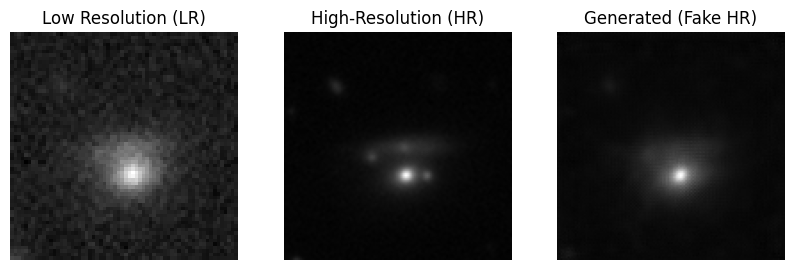

MSE Loss : 0.0003801000420935452 || PSNR : 34.20102104854261 || SSIM : 0.8871019219944244


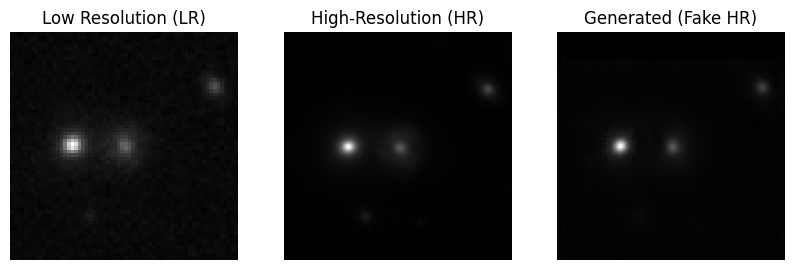

MSE Loss : 0.00020508182933554053 || PSNR : 36.88072835787533 || SSIM : 0.8924985755534302


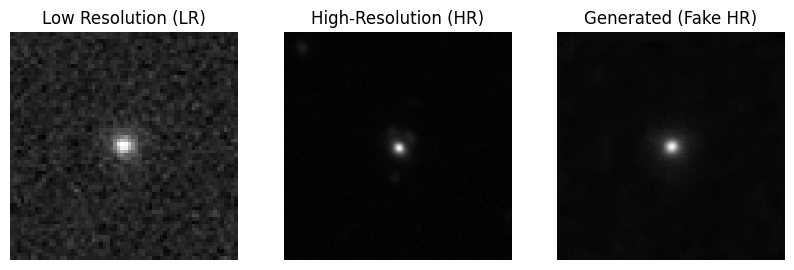

MSE Loss : 0.0007708113989792764 || PSNR : 31.13051895349777 || SSIM : 0.680482773240921


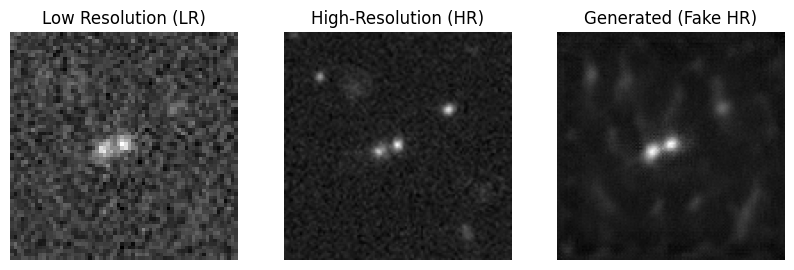

MSE Loss : 0.005922401323914528 || PSNR : 22.27502201899767 || SSIM : 0.4144834769316302


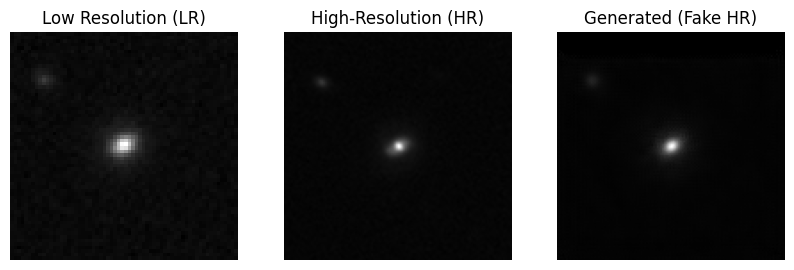

MSE Loss : 0.00018315365014132112 || PSNR : 37.37184406252796 || SSIM : 0.8154380874759855


In [12]:
def visualize(model,idx,dataset_test):
    model.to(device)
    hr_img = dataset_test[idx][1].to(device).squeeze()  # Move HR image to device
    lr_img = dataset_test[idx][0].unsqueeze(0).to(device)  # Move LR image to device

    with torch.no_grad():
        fake_hr_img = model(lr_img).squeeze().cpu().numpy()  # Move output to CPU for numpy
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # plot LR Image
    axes[0].imshow(lr_img.squeeze().cpu().numpy(), cmap='gray')  # Use cmap='gray' for grayscale images
    axes[0].set_title("Low Resolution (LR)")
    axes[0].axis("off")
    
    # Plot HR image
    axes[1].imshow(hr_img.squeeze().cpu().numpy(), cmap='gray')  # Use cmap='gray' for grayscale images
    axes[1].set_title("High-Resolution (HR)")
    axes[1].axis("off")
    
    # Plot Fake HR image
    axes[2].imshow(fake_hr_img.squeeze(), cmap='gray')
    axes[2].set_title("Generated (Fake HR)")
    axes[2].axis("off")
    
    # Show the images
    plt.show()
    print(f'MSE Loss : {mse(hr_img.cpu().numpy(),fake_hr_img)}',end=' || ')
    print(f'PSNR : {psnr(hr_img.cpu().numpy(),fake_hr_img)}',end=' || ')
    print(f'SSIM : {calculate_ssim(hr_img.cpu().numpy(),fake_hr_img)}')


samples = np.random.randint(0,len(dataset_test)-1,5)
for idx in samples:
    visualize(generator,idx,dataset_test)